# Final Highway Network Experiment Analysis
This one uses the increase_ego_reward_importance setting and estimates the objective weights of the uncontrolled vehicles

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob 
import os
import matplotlib.pyplot as plt
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from src.utils import calc_hypervolume

## Loading the data

In [3]:
def load_merged_dataframe(literal_str):
    file_list = glob.glob(literal_str)
    df = pd.concat(map(pd.read_csv, file_list), ignore_index=True)
    return df

In [4]:
#load the data
#first two configs
summary_files = os.path.join("data/moma_highway_test_final_estimates_weights/", "moma_highway_test_final_estimates_weights*summary.csv")
detail_files = os.path.join("data/moma_highway_test_final_estimates_weights/", "moma_highway_test_final_estimates_weights*detail.csv")
loss_files = os.path.join("data/moma_highway_test_final_estimates_weights/", "moma_highway_test_final_estimates_weights*loss.csv")

df_summary = load_merged_dataframe(summary_files)
df_detail = load_merged_dataframe(detail_files)
df_loss = load_merged_dataframe(loss_files)

In [5]:
print("Summary:")
df_summary.info()
print("Detail:")
df_detail.info()
print("Loss")
df_loss.info()

Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57600 entries, 0 to 57599
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         57600 non-null  int64  
 1   repetition_number                  57600 non-null  int64  
 2   weight_index                       57600 non-null  int64  
 3   weight_tuple                       57600 non-null  object 
 4   num_iterations                     57600 non-null  int64  
 5   vehicle_id                         57600 non-null  int64  
 6   normalised_speed_reward            57600 non-null  float64
 7   normalised_energy_reward           57600 non-null  float64
 8   raw_speed_reward                   57600 non-null  float64
 9   raw_energy_reward                  57600 non-null  float64
 10  env_config_id                      57600 non-null  int64  
 11  experiment_id                      57600 non-

## Data Preprocessing

In [6]:
def add_cv_ratio(df):
    df["controlled_vehicle_ratio"] = 0.0
    df.loc[df["env_config_id"] == 0, "controlled_vehicle_ratio"] = 2/20
    df.loc[df["env_config_id"] == 1, "controlled_vehicle_ratio"] = 8/20
    df.loc[df["env_config_id"] == 2, "controlled_vehicle_ratio"] = 14/20
    return df

def shorten_reward_structure_names(df):
    #exclude the suffix "reward" for entries the reward structure column
    df["reward_structure"] = df["reward_structure"].apply(lambda row: row.split("_")[0])

    #remap the use_multi_dqn column to explicitly state the employed reward structure
    df["use_multi_dqn"] = df["use_multi_dqn"].astype(str)
    df.loc[df["use_multi_dqn"] == "False","use_multi_dqn"] = "basic"
    df.loc[df["use_multi_dqn"] == "True","use_multi_dqn"] = "separated"
    return df

def add_config_names(df):
    df["alg_config"] = df.apply(lambda row : f"NS_{row["use_multi_dqn"]}_RS_{row["reward_structure"]}", axis=1)
    print(df["alg_config"].value_counts())

    df["exp_config"] = df.apply(lambda row : f"CVR_{row["controlled_vehicle_ratio"]}_NS_{row["use_multi_dqn"]}_RS_{row["reward_structure"]}", axis=1)
    print(df["exp_config"].value_counts())

    return df

def extend_dataframe(df):
    df = add_cv_ratio(df)
    df = shorten_reward_structure_names(df)
    df = add_config_names(df)
    return df

In [7]:
df_summary = extend_dataframe(df_summary)
df_detail = extend_dataframe(df_detail)
df_loss = extend_dataframe(df_loss)
df_summary["controlled_vehicle_ratio"].value_counts()
df_summary["speed_weight"] = df_summary["weight_index"] / df_summary["weight_index"].max()

alg_config
NS_separated_RS_mean    19200
NS_basic_RS_ego         19200
NS_basic_RS_mean        19200
Name: count, dtype: int64
exp_config
CVR_0.7_NS_basic_RS_ego         11200
CVR_0.7_NS_separated_RS_mean    11200
CVR_0.7_NS_basic_RS_mean        11200
CVR_0.4_NS_separated_RS_mean     6400
CVR_0.4_NS_basic_RS_mean         6400
CVR_0.4_NS_basic_RS_ego          6400
CVR_0.1_NS_basic_RS_ego          1600
CVR_0.1_NS_separated_RS_mean     1600
CVR_0.1_NS_basic_RS_mean         1600
Name: count, dtype: int64
alg_config
NS_separated_RS_mean    3495240
NS_basic_RS_mean        3321440
NS_basic_RS_ego         2849600
Name: count, dtype: int64
exp_config
CVR_0.7_NS_separated_RS_mean    1221480
CVR_0.4_NS_separated_RS_mean    1188960
CVR_0.1_NS_basic_RS_mean        1135120
CVR_0.7_NS_basic_RS_mean        1111280
CVR_0.1_NS_separated_RS_mean    1084800
CVR_0.1_NS_basic_RS_ego         1082000
CVR_0.4_NS_basic_RS_mean        1075040
CVR_0.4_NS_basic_RS_ego          891040
CVR_0.7_NS_basic_RS_ego       

In [8]:
#exclude the suffix "reward" for entries the reward structure column
df_summary["reward_structure"] = df_summary["reward_structure"].apply(lambda row: row.split("_")[0])

#remap the use_multi_dqn column to explicitly state the employed reward structure
df_summary["use_multi_dqn"] = df_summary["use_multi_dqn"].astype(str)
df_summary.loc[df_summary["use_multi_dqn"] == "False","use_multi_dqn"] = "basic"
df_summary.loc[df_summary["use_multi_dqn"] == "True","use_multi_dqn"] = "separated"

In [9]:
print(df_summary["reward_structure"].value_counts())
print(df_summary["use_multi_dqn"].value_counts())

reward_structure
mean    38400
ego     19200
Name: count, dtype: int64
use_multi_dqn
basic        38400
separated    19200
Name: count, dtype: int64


In [10]:
# add experiment configuration name
df_summary["alg_config"] = df_summary.apply(lambda row : f"NS_{row["use_multi_dqn"]}_RS_{row["reward_structure"]}", axis=1)
print(df_summary["alg_config"].value_counts())

df_summary["exp_config"] = df_summary.apply(lambda row : f"CVR_{row["controlled_vehicle_ratio"]}_NS_{row["use_multi_dqn"]}_RS_{row["reward_structure"]}", axis=1)
print(df_summary["exp_config"].value_counts())

alg_config
NS_separated_RS_mean    19200
NS_basic_RS_ego         19200
NS_basic_RS_mean        19200
Name: count, dtype: int64
exp_config
CVR_0.7_NS_basic_RS_ego         11200
CVR_0.7_NS_separated_RS_mean    11200
CVR_0.7_NS_basic_RS_mean        11200
CVR_0.4_NS_separated_RS_mean     6400
CVR_0.4_NS_basic_RS_mean         6400
CVR_0.4_NS_basic_RS_ego          6400
CVR_0.1_NS_basic_RS_ego          1600
CVR_0.1_NS_separated_RS_mean     1600
CVR_0.1_NS_basic_RS_mean         1600
Name: count, dtype: int64


## Data Analysis

### Pareto front estimation

Text(0.5, 0, 'Normalised Speed Reward')

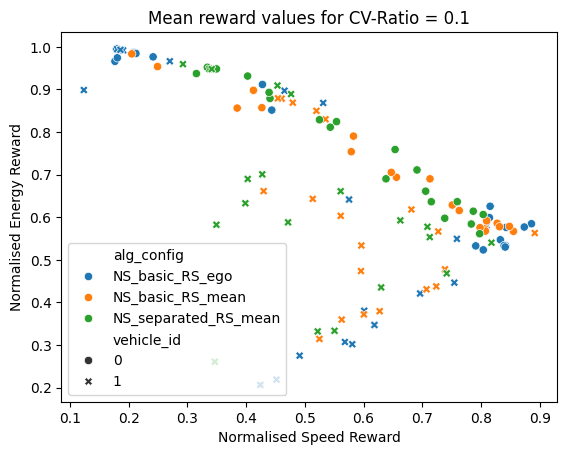

In [11]:
grouped_df = df_summary[df_summary["controlled_vehicle_ratio"]==0.1].groupby(["alg_config","weight_index", "vehicle_id"])[["normalised_energy_reward", "normalised_speed_reward"]].mean()
ax = sns.scatterplot(grouped_df, x="normalised_speed_reward", y="normalised_energy_reward", style="vehicle_id",hue="alg_config")
ax.set_title("Mean reward values for CV-Ratio = 0.1")
ax.set_ylabel("Normalised Energy Reward")
ax.set_xlabel("Normalised Speed Reward")

This plot shows how for this specific cv ratio, the baseline algorithm does best, supposedly because they only care about their own reward. For the mean algo's on the other hand, the vehicle rewards have a lower variance because they care about the rewards of other vehicles as well. If that first impression holds, we will see when looking at the boxplots.

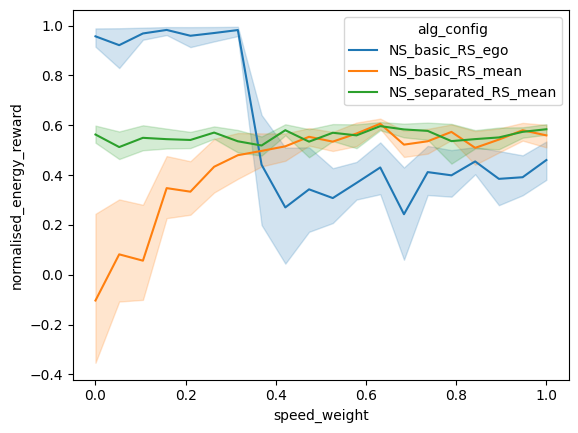

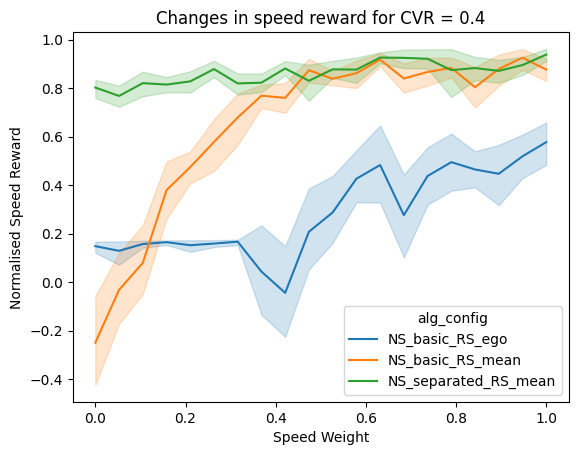

In [12]:
#TODO: two lineplots: one for the energy reward, one for the speeds reward chosing how they change when increasing the preference for speed, i.e. weight index on the x-axis
grouped_df = df_summary[df_summary["controlled_vehicle_ratio"]==0.4].groupby(["alg_config","speed_weight", "vehicle_id"])[["normalised_energy_reward","normalised_speed_reward"]].mean()
sns.lineplot(grouped_df, x="speed_weight", y="normalised_energy_reward", hue="alg_config")
plt.show()
ax = sns.lineplot(grouped_df, x="speed_weight", y="normalised_speed_reward", hue="alg_config")
ax.set_ylabel("Normalised Speed Reward")
ax.set_xlabel("Speed Weight")
ax.set_title("Changes in speed reward for CVR = 0.4")
plt.show()

#0.4 ratio

The ego one does way better than the mean ones in producing very different policies when changing the preferences. This can be attributed to them not caring about other vehicles. The mean ones on the other hand have a much more subtle change in rewards when changing the weight index. This might be caused by several factors. First off, they care about the other vehicle's returns, so they might use different actions because it would increase the mean utility for the close vehicles. Interestingly, when increasing the ratio of vehicles that are controlled to 0.7, the ego algorithm behaves the same, which might be because the controlled vehicles are actually impeding with each other, everyone trying to get out on top (indicated by the high variation is speeds), while the variance for the mean algorithms, the mean separated one in particular, are much lower. This indicates that is has an easier time accurately assessing the social q-values for the close vehicles.

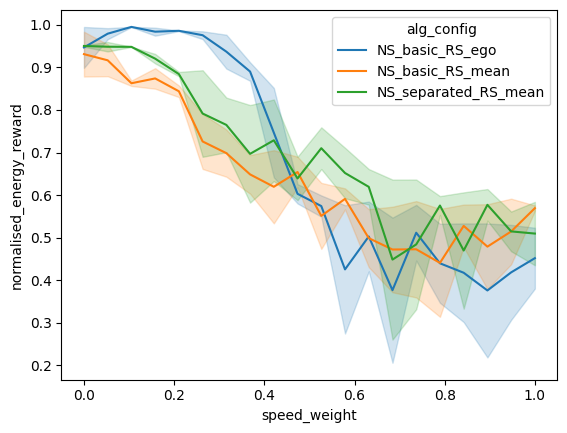

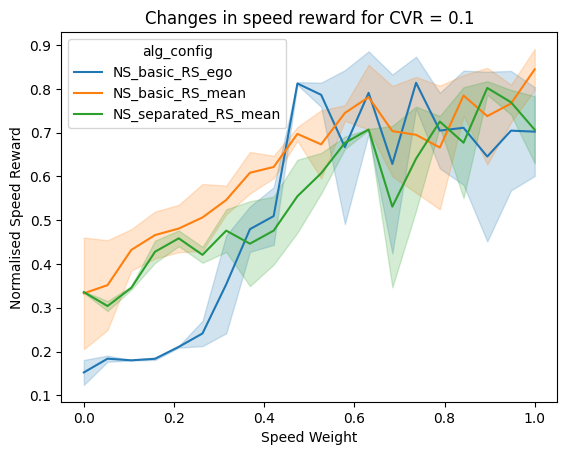

In [13]:
grouped_df = df_summary[df_summary["controlled_vehicle_ratio"]==0.1].groupby(["alg_config","speed_weight", "vehicle_id"])[["normalised_energy_reward","normalised_speed_reward"]].mean()
ax = sns.lineplot(grouped_df, x="speed_weight", y="normalised_energy_reward", hue="alg_config")
ax.set_ylabel("Normalised Energy Reward")
ax.set_xlabel("Speed Weight")
ax.set_title("Changes in energy reward for CVR = 0.1")
plt.show()
ax = sns.lineplot(grouped_df, x="speed_weight", y="normalised_speed_reward", hue="alg_config")
ax.set_ylabel("Normalised Speed Reward")
ax.set_xlabel("Speed Weight")
ax.set_title("Changes in speed reward for CVR = 0.1")
plt.show()

#0.4 ratio

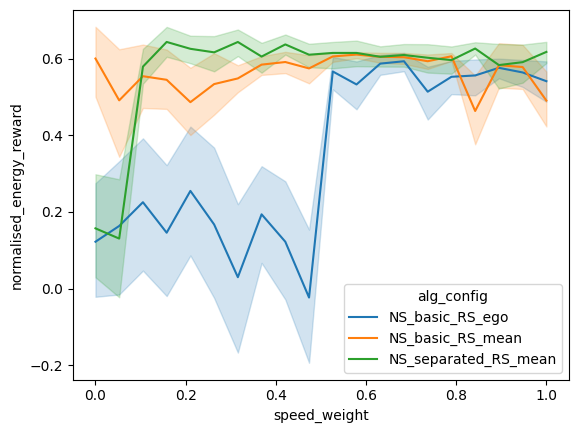

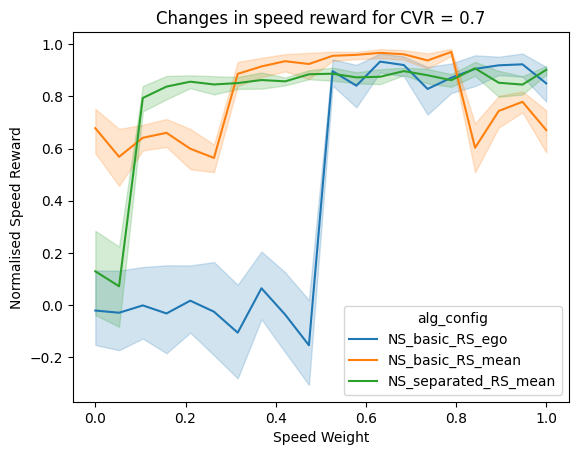

In [14]:
grouped_df = df_summary[df_summary["controlled_vehicle_ratio"]==0.7].groupby(["alg_config","speed_weight", "vehicle_id"])[["normalised_energy_reward","normalised_speed_reward"]].mean()
sns.lineplot(grouped_df, x="speed_weight", y="normalised_energy_reward", hue="alg_config")
plt.show()
ax = sns.lineplot(grouped_df, x="speed_weight", y="normalised_speed_reward", hue="alg_config")
ax.set_ylabel("Normalised Speed Reward")
ax.set_xlabel("Speed Weight")
ax.set_title("Changes in speed reward for CVR = 0.7")
plt.show()

#0.7 ratio

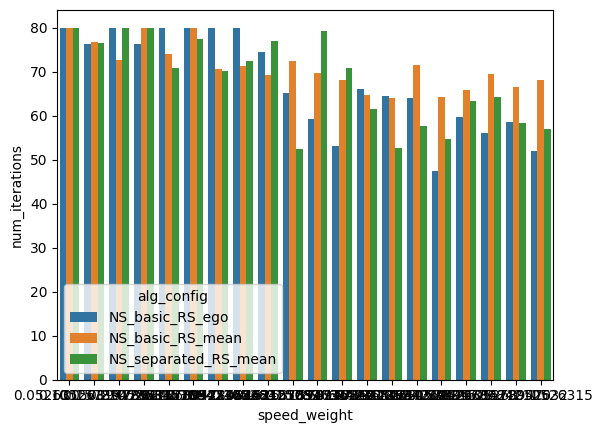

In [15]:
#TODO: num iterations before a crash
grouped_df = df_summary[df_summary["controlled_vehicle_ratio"]==0.1].groupby(["alg_config","speed_weight", "vehicle_id"])[["num_iterations"]].mean()
sns.barplot(grouped_df, x="speed_weight", y="num_iterations", hue="alg_config")
plt.show()

All approximately the same

### Plots of hypervolume distribution among vehicles of the same experiment

In [16]:
#compute hypervolume for all vehicles
hv_data = []
grouped_data = df_summary.groupby(["controlled_vehicle_ratio","alg_config","vehicle_id"])
for (cvr, alg_config, vehicle_id), group in grouped_data:
    group_data = group[["normalised_speed_reward","normalised_energy_reward"]].to_numpy()
    hv = calc_hypervolume(reward_vector=group_data)
    hv_data.append({"controlled_vehicle_ratio": cvr, "alg_config":alg_config, "vehicle_id": vehicle_id, "hypervolume":hv})

hv_df = pd.DataFrame(hv_data)
display(hv_df)
#TODO: construct scatterplot and then boxplot of the hypervolumes for the vehicles grouped by ratio of controlled vehicles and by reward/network structure
#compute hypervolume




Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.warnings['not_compiled'] = False



,controlled_vehicle_ratio,alg_config,vehicle_id,hypervolume
0,0.1,NS_basic_RS_ego,0,0.818810
1,0.1,NS_basic_RS_ego,1,0.815884
2,0.1,NS_basic_RS_mean,0,0.812696
3,0.1,NS_basic_RS_mean,1,0.819680
4,0.1,NS_separated_RS_mean,0,0.816193
...,...,...,...,...
67,0.7,NS_separated_RS_mean,9,0.795647
68,0.7,NS_separated_RS_mean,10,0.808525
69,0.7,NS_separated_RS_mean,11,0.795278
70,0.7,NS_separated_RS_mean,12,0.822367


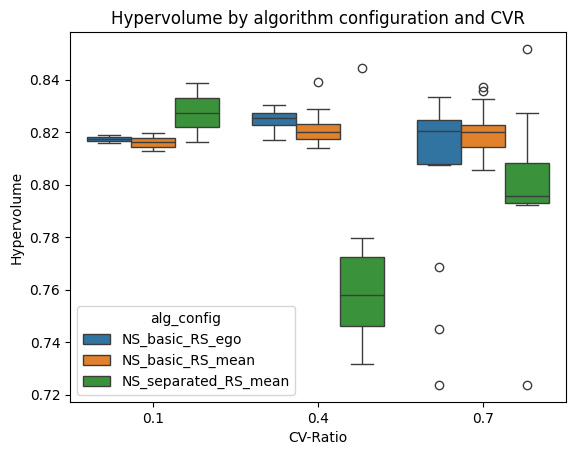

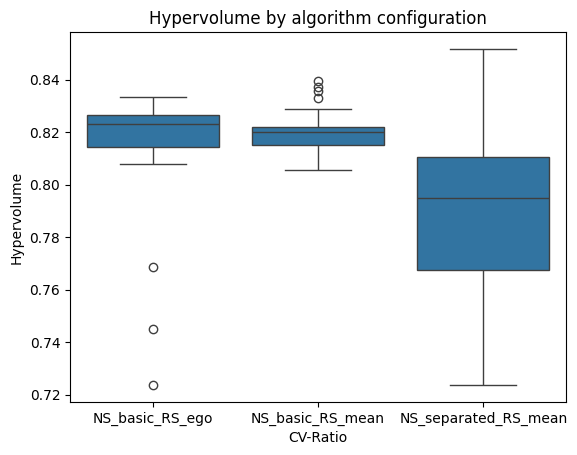

In [17]:
ax = sns.boxplot(hv_df, x="controlled_vehicle_ratio", y="hypervolume", hue="alg_config")
ax.set_ylabel("Hypervolume")
ax.set_xlabel("CV-Ratio")
ax.set_title("Hypervolume by algorithm configuration and CVR")
plt.show()

#avg hypervolume
ax = sns.boxplot(hv_df, x="alg_config", y="hypervolume")
ax.set_ylabel("Hypervolume")
ax.set_xlabel("CV-Ratio")
ax.set_title("Hypervolume by algorithm configuration")
plt.show()
#TODO: hypothesis: the hypervolume is dependent on the vehicle id, 
# because of they way they are spawned (one vehicle is always first, 
# has an easier time optimising their reward as they don't have as many vehicles to overtake): 
# color the dots in the scatterplot by the vehicle_id to see if there is. 
# If that is to messy to see something, try using a barplot/lineplot 
# with the vehicle ID on the x axis and the hypervolume on the y axis

<Axes: xlabel='vehicle_id', ylabel='hypervolume'>

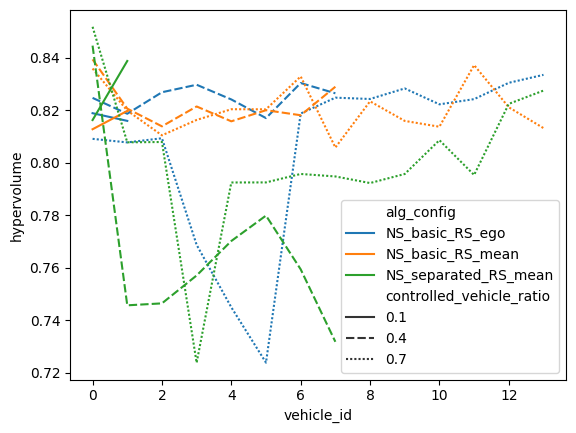

In [18]:
sns.lineplot(hv_df, x="vehicle_id", y="hypervolume", hue="alg_config", style="controlled_vehicle_ratio")

### Loss analysis

In [19]:
df_loss

,Unnamed: 0,episode,loss,hypervolume,avg_num_iterations_training,std_num_iterations_training,env_config_id,experiment_id,replay_buffer_size,batch_size,reward_structure,use_multi_dqn,observation_space_name,increase_ego_reward_importance,estimate_uncontrolled_obj_weights,controlled_vehicle_ratio,alg_config,exp_config
0,0,NaN,NaN,0.254176,53.28,30.647278,1,2,10000,100,mean,basic,OccupancyGrid,True,True,0.4,NS_basic_RS_mean,CVR_0.4_NS_basic_RS_mean
1,1,1.0,0.294652,NaN,NaN,NaN,1,2,10000,100,mean,basic,OccupancyGrid,True,True,0.4,NS_basic_RS_mean,CVR_0.4_NS_basic_RS_mean
2,2,2.0,0.312252,NaN,NaN,NaN,1,2,10000,100,mean,basic,OccupancyGrid,True,True,0.4,NS_basic_RS_mean,CVR_0.4_NS_basic_RS_mean
3,3,3.0,0.301577,NaN,NaN,NaN,1,2,10000,100,mean,basic,OccupancyGrid,True,True,0.4,NS_basic_RS_mean,CVR_0.4_NS_basic_RS_mean
4,4,4.0,0.350730,NaN,NaN,NaN,1,2,10000,100,mean,basic,OccupancyGrid,True,True,0.4,NS_basic_RS_mean,CVR_0.4_NS_basic_RS_mean
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35995,1995,1995.0,0.961836,NaN,NaN,NaN,0,0,10000,100,ego,basic,OccupancyGrid,True,True,0.1,NS_basic_RS_ego,CVR_0.1_NS_basic_RS_ego
35996,1996,1996.0,0.915382,NaN,NaN,NaN,0,0,10000,100,ego,basic,OccupancyGrid,True,True,0.1,NS_basic_RS_ego,CVR_0.1_NS_basic_RS_ego
35997,1997,1997.0,0.900421,NaN,NaN,NaN,0,0,10000,100,ego,basic,OccupancyGrid,True,True,0.1,NS_basic_RS_ego,CVR_0.1_NS_basic_RS_ego
35998,1998,1998.0,0.831152,NaN,NaN,NaN,0,0,10000,100,ego,basic,OccupancyGrid,True,True,0.1,NS_basic_RS_ego,CVR_0.1_NS_basic_RS_ego


In [20]:
#TODO: look at how the loss (and maybe the hypervolume) changes while training for all the algorithm configurations
grouped_df = df_loss.groupby(["alg_config", "controlled_vehicle_ratio", "episode"])["loss"].mean()
grouped_df = grouped_df.reset_index()
display(grouped_df)

,alg_config,controlled_vehicle_ratio,episode,loss
0,NS_basic_RS_ego,0.1,0.0,0.264225
1,NS_basic_RS_ego,0.1,1.0,0.311265
2,NS_basic_RS_ego,0.1,2.0,0.388571
3,NS_basic_RS_ego,0.1,3.0,0.459752
4,NS_basic_RS_ego,0.1,4.0,0.709059
...,...,...,...,...
17992,NS_separated_RS_mean,0.7,1995.0,0.895188
17993,NS_separated_RS_mean,0.7,1996.0,0.961141
17994,NS_separated_RS_mean,0.7,1997.0,1.334000
17995,NS_separated_RS_mean,0.7,1998.0,1.284112


<Axes: xlabel='episode', ylabel='loss'>

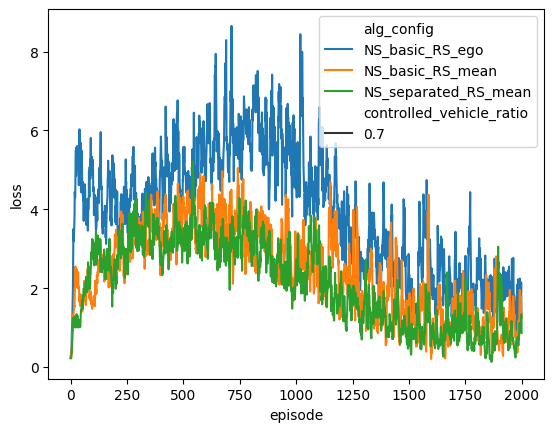

In [21]:
sns.lineplot(grouped_df[grouped_df["controlled_vehicle_ratio"] == 0.7], x="episode", y="loss", hue="alg_config", style="controlled_vehicle_ratio")

### Detail df analysis

In [22]:
df_detail["speed_diff"] = np.abs(df_detail["target_speed"] - df_detail["curr_speed"])
df_detail["abs_acc"] = np.abs(df_detail["acc"])
df_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9666280 entries, 0 to 9666279
Data columns (total 28 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   Unnamed: 0                         int64  
 1   repetition_number                  int64  
 2   weight_index                       int64  
 3   weight_tuple                       object 
 4   iteration                          int64  
 5   vehicle_id                         int64  
 6   controlled_flag                    int64  
 7   action                             float64
 8   target_speed                       float64
 9   curr_speed                         float64
 10  acc                                float64
 11  lane                               int64  
 12  curr_speed_reward                  float64
 13  curr_energy_reward                 float64
 14  env_config_id                      int64  
 15  experiment_id                      int64  
 16  replay_buffer_size

In [23]:
grouped_df = df_detail.groupby(["alg_config","controlled_flag", "controlled_vehicle_ratio", "repetition_number","iteration"])["abs_acc"].mean()
grouped_df = grouped_df.reset_index()
display(grouped_df)

,alg_config,controlled_flag,controlled_vehicle_ratio,repetition_number,iteration,abs_acc
0,NS_basic_RS_ego,0,0.1,0,0,1.256823
1,NS_basic_RS_ego,0,0.1,0,1,0.470996
2,NS_basic_RS_ego,0,0.1,0,2,0.328585
3,NS_basic_RS_ego,0,0.1,0,3,0.255208
4,NS_basic_RS_ego,0,0.1,0,4,0.230021
...,...,...,...,...,...,...
28795,NS_separated_RS_mean,1,0.7,19,75,0.010159
28796,NS_separated_RS_mean,1,0.7,19,76,0.004432
28797,NS_separated_RS_mean,1,0.7,19,77,0.006648
28798,NS_separated_RS_mean,1,0.7,19,78,0.007064


### uncontrolled vehicles

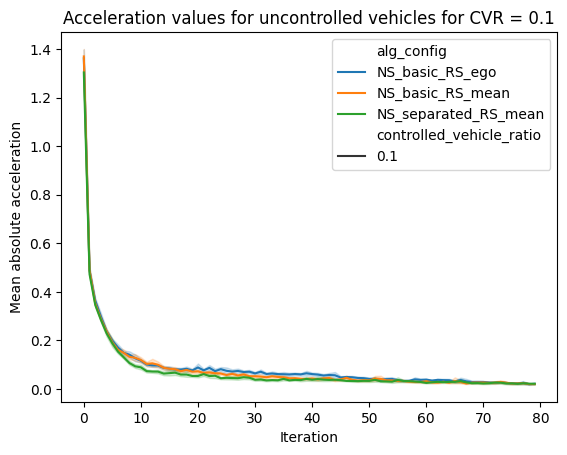

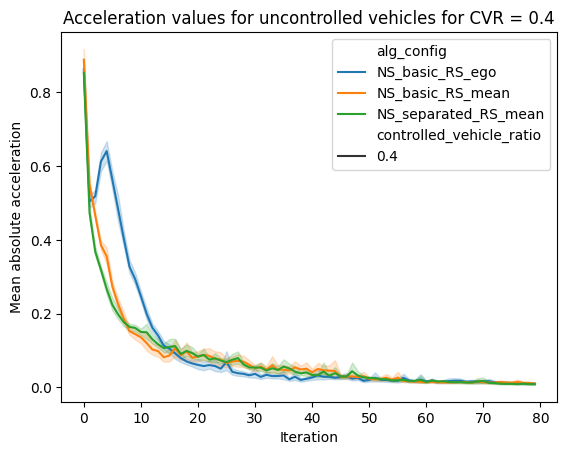

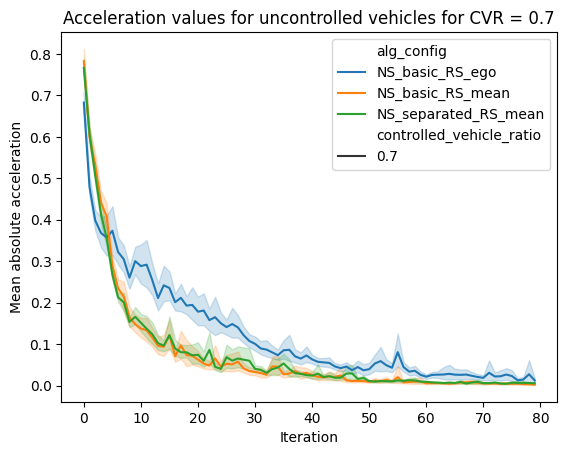

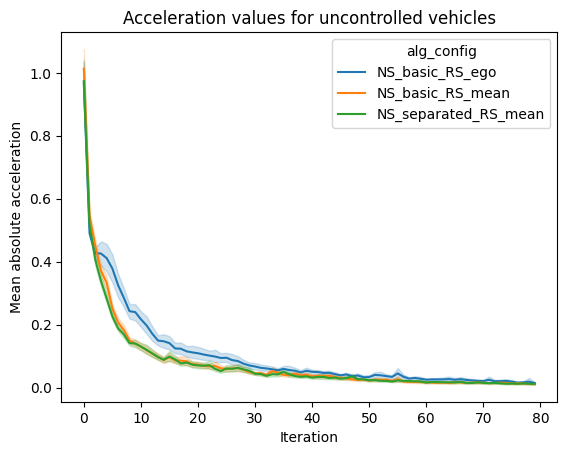

In [24]:
data = grouped_df[grouped_df["controlled_flag"] == 0]
ax = sns.lineplot(data[data["controlled_vehicle_ratio"] == 0.1], x="iteration", y="abs_acc", hue="alg_config", style="controlled_vehicle_ratio")
ax.set_ylabel("Mean absolute acceleration")
ax.set_xlabel("Iteration")
ax.set_title("Acceleration values for uncontrolled vehicles for CVR = 0.1")
plt.show()
ax = sns.lineplot(data[data["controlled_vehicle_ratio"] == 0.4], x="iteration", y="abs_acc", hue="alg_config", style="controlled_vehicle_ratio")
ax.set_ylabel("Mean absolute acceleration")
ax.set_xlabel("Iteration")
ax.set_title("Acceleration values for uncontrolled vehicles for CVR = 0.4")
plt.show()
ax = sns.lineplot(data[data["controlled_vehicle_ratio"] == 0.7], x="iteration", y="abs_acc", hue="alg_config", style="controlled_vehicle_ratio")
ax.set_ylabel("Mean absolute acceleration")
ax.set_xlabel("Iteration")
ax.set_title("Acceleration values for uncontrolled vehicles for CVR = 0.7")
plt.show()

#averaged over all cvr's
ax = sns.lineplot(data, x="iteration", y="abs_acc", hue="alg_config")
ax.set_ylabel("Mean absolute acceleration")
ax.set_xlabel("Iteration")
ax.set_title("Acceleration values for uncontrolled vehicles")
plt.show()

### speed

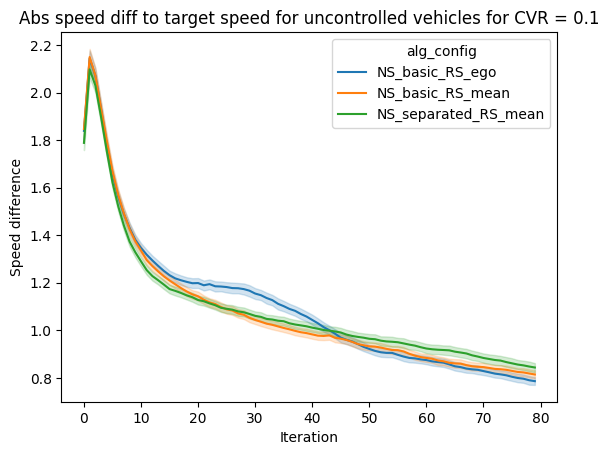

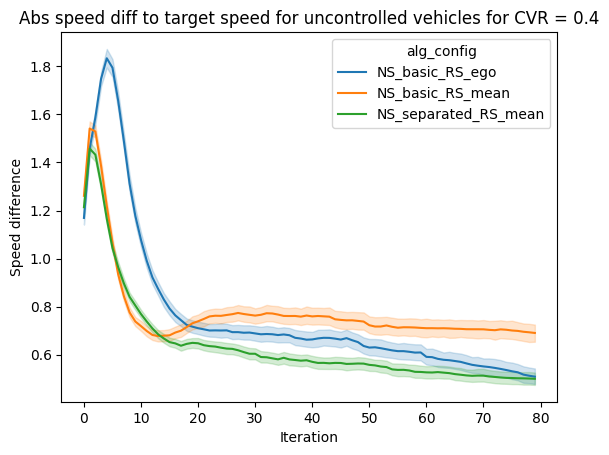

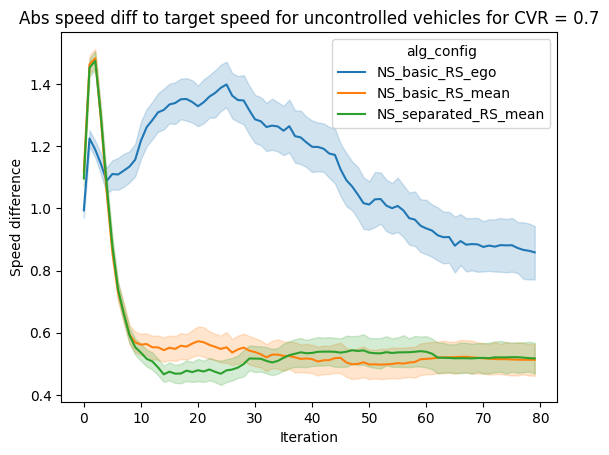

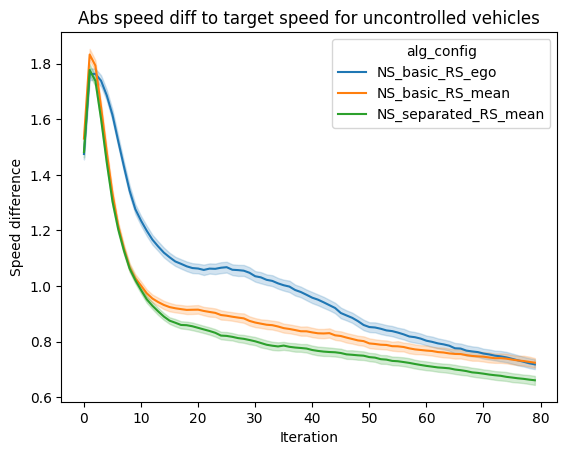

In [25]:
ax = sns.lineplot(df_detail[(df_detail["controlled_flag"]==0) & (df_detail["controlled_vehicle_ratio"] == 0.1)], x="iteration", y="speed_diff", hue="alg_config")
ax.set_ylabel("Speed difference")
ax.set_xlabel("Iteration")
ax.set_title("Abs speed diff to target speed for uncontrolled vehicles for CVR = 0.1")
plt.show()
ax = sns.lineplot(df_detail[(df_detail["controlled_flag"]==0) & (df_detail["controlled_vehicle_ratio"] == 0.4)], x="iteration", y="speed_diff", hue="alg_config")
ax.set_ylabel("Speed difference")
ax.set_xlabel("Iteration")
ax.set_title("Abs speed diff to target speed for uncontrolled vehicles for CVR = 0.4")
plt.show()
ax = sns.lineplot(df_detail[(df_detail["controlled_flag"]==0) & (df_detail["controlled_vehicle_ratio"] == 0.7)], x="iteration", y="speed_diff", hue="alg_config")
ax.set_ylabel("Speed difference")
ax.set_xlabel("Iteration")
ax.set_title("Abs speed diff to target speed for uncontrolled vehicles for CVR = 0.7")
plt.show()

#averaged over all cv ratios
ax = sns.lineplot(df_detail[(df_detail["controlled_flag"]==0)], x="iteration", y="speed_diff", hue="alg_config")
ax.set_ylabel("Speed difference")
ax.set_xlabel("Iteration")
ax.set_title("Abs speed diff to target speed for uncontrolled vehicles")
plt.show()